In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 224ms/step - loss: 0.3701 - root_mean_squared_error: 0.6083 - val_loss: 0.2782 - val_root_mean_squared_error: 0.5274
Epoch 2/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1892 - root_mean_squared_error: 0.4349 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3375
Epoch 3/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0982 - root_mean_squared_error: 0.3133 - val_loss: 0.1005 - val_root_mean_squared_error: 0.3170
Epoch 4/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0896 - root_mean_squared_error: 0.2994 - val_loss: 0.0934 - val_root_mean_squared_error: 0.3056
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0814 - root_mean_squared_error: 0.2853 - val_loss: 0.0869 - val_root_mean_squared_error: 0.2948
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0735 - root_mean_squared_error: 0.2711 - val_loss: 0.0781 

53/53 [==============================] - 10s 188ms/step - loss: 0.0137 - root_mean_squared_error: 0.1172 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 32/50
53/53 [==============================] - 7s 133ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 33/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0134 - root_mean_squared_error: 0.1157 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 34/50
53/53 [==============================] - 1s 19ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324
Epoch 35/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 36/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.0135 - val_root_mean

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.504922866821289 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

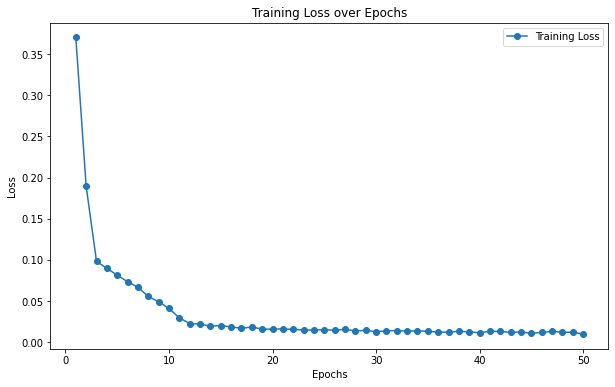

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

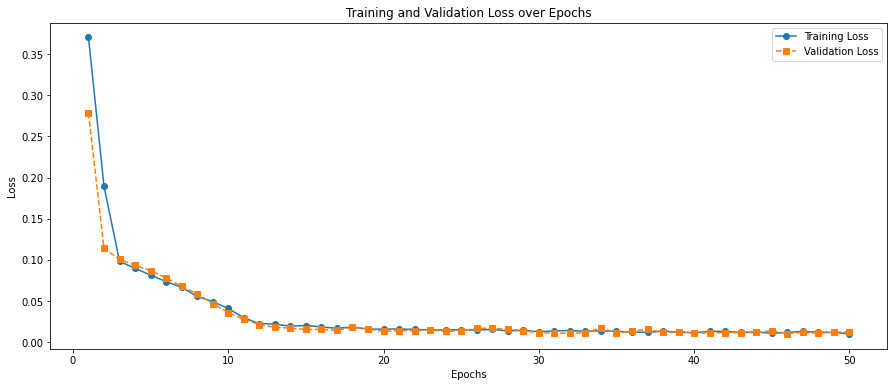

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 14ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10193021160067879
MAE : 0.07871645392668021


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.363688e+06,1053272.694
1,8.669811e+05,368862.123
2,8.388424e+05,979418.298
3,1.524321e+06,2086269.569
4,2.464150e+06,2852731.016
5,3.224629e+06,3452823.613
6,3.709011e+06,3846843.974
7,3.942366e+06,4005222.451
8,4.030837e+06,4129684.505
9,3.913809e+06,4130311.577


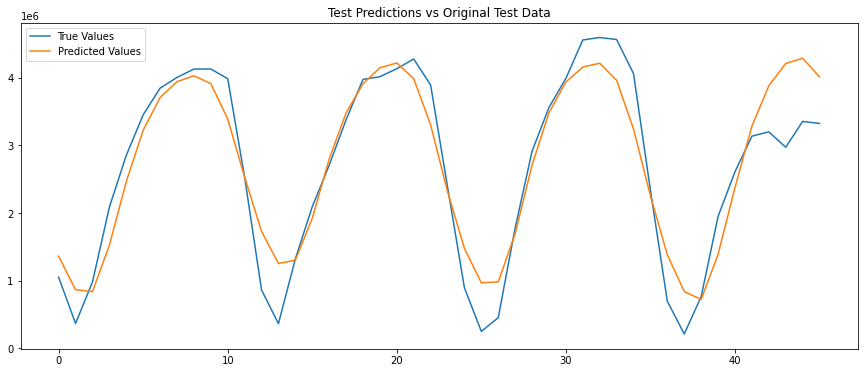

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

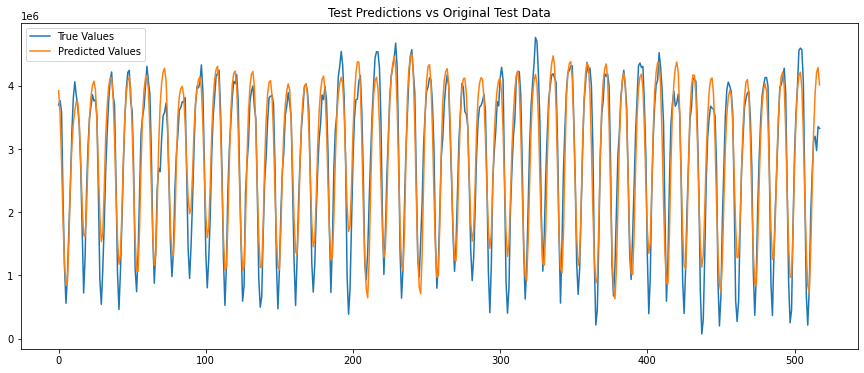

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()